In [1]:
import pyemma as pm
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import pandas as pd
import functions as funcs
import pickle
import time
import seaborn as sns

In [2]:
timescales = pd.read_hdf('timescales.h5')
timescales['num_its'] = timescales['num_its'].astype(int)
timescales['hp_index'] = timescales['hp_index'].astype(int)

data_dir = Path('/Volumes/REA/Data/fast_folders/model_comparisons/')


In [3]:
timescales = timescales.groupby(['protein', 'hp_index', 'num_its', 'lag'], as_index=False).agg(
                            median = ("value", lambda x: np.quantile(x, 0.5)), 
                            lb= ("value", lambda x: np.quantile(x, 0.025)), 
                            ub = ("value", lambda x: np.quantile(x, 0.975)))
timescales['lb_diff'] = timescales['median'] - timescales['lb']
timescales['ub_diff'] = timescales['ub'] - timescales['median']
timescales.head()

,protein,hp_index,num_its,lag,median,lb,ub,lb_diff,ub_diff
0,BBA,0,2,10.0,685.337760,565.724676,1060.147961,119.613084,374.810202
1,BBA,0,2,20.0,1027.890242,871.405174,1328.090976,156.485068,300.200734
2,BBA,0,2,30.0,1271.702454,1094.700741,1686.354349,177.001713,414.651894
3,BBA,0,2,40.0,1501.259543,1277.074258,2070.079460,224.185285,568.819917
4,BBA,0,2,50.0,1696.696799,1405.683312,2531.717636,291.013487,835.020836


In [5]:
chosen_lags = pd.read_hdf('chosen_lag_times.h5')
chosen_ks = pd.read_hdf('chosen_num_dominant.h5')

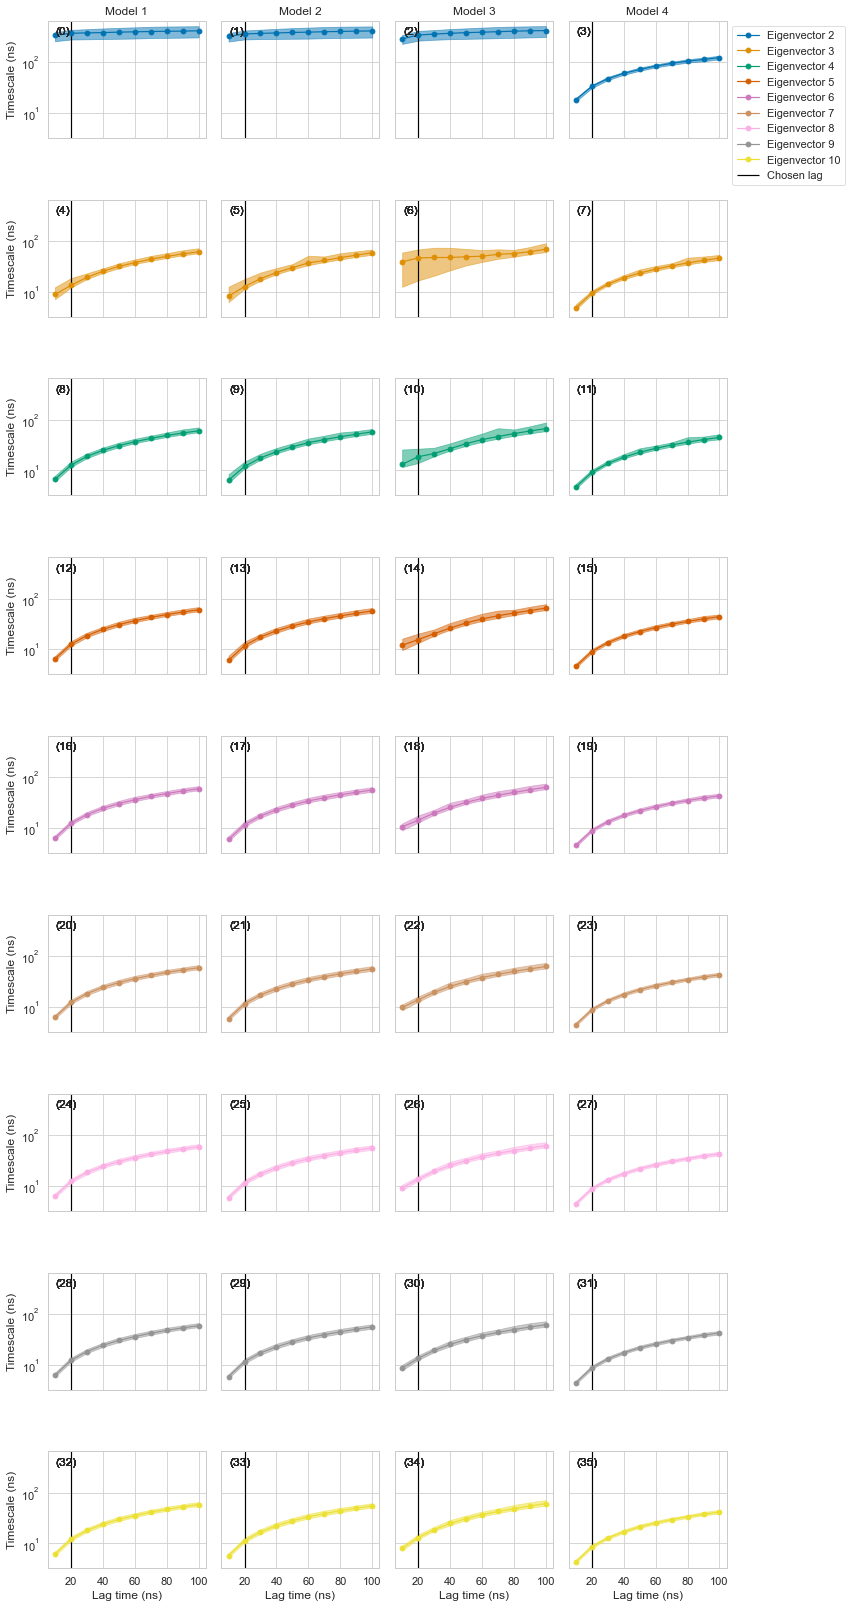

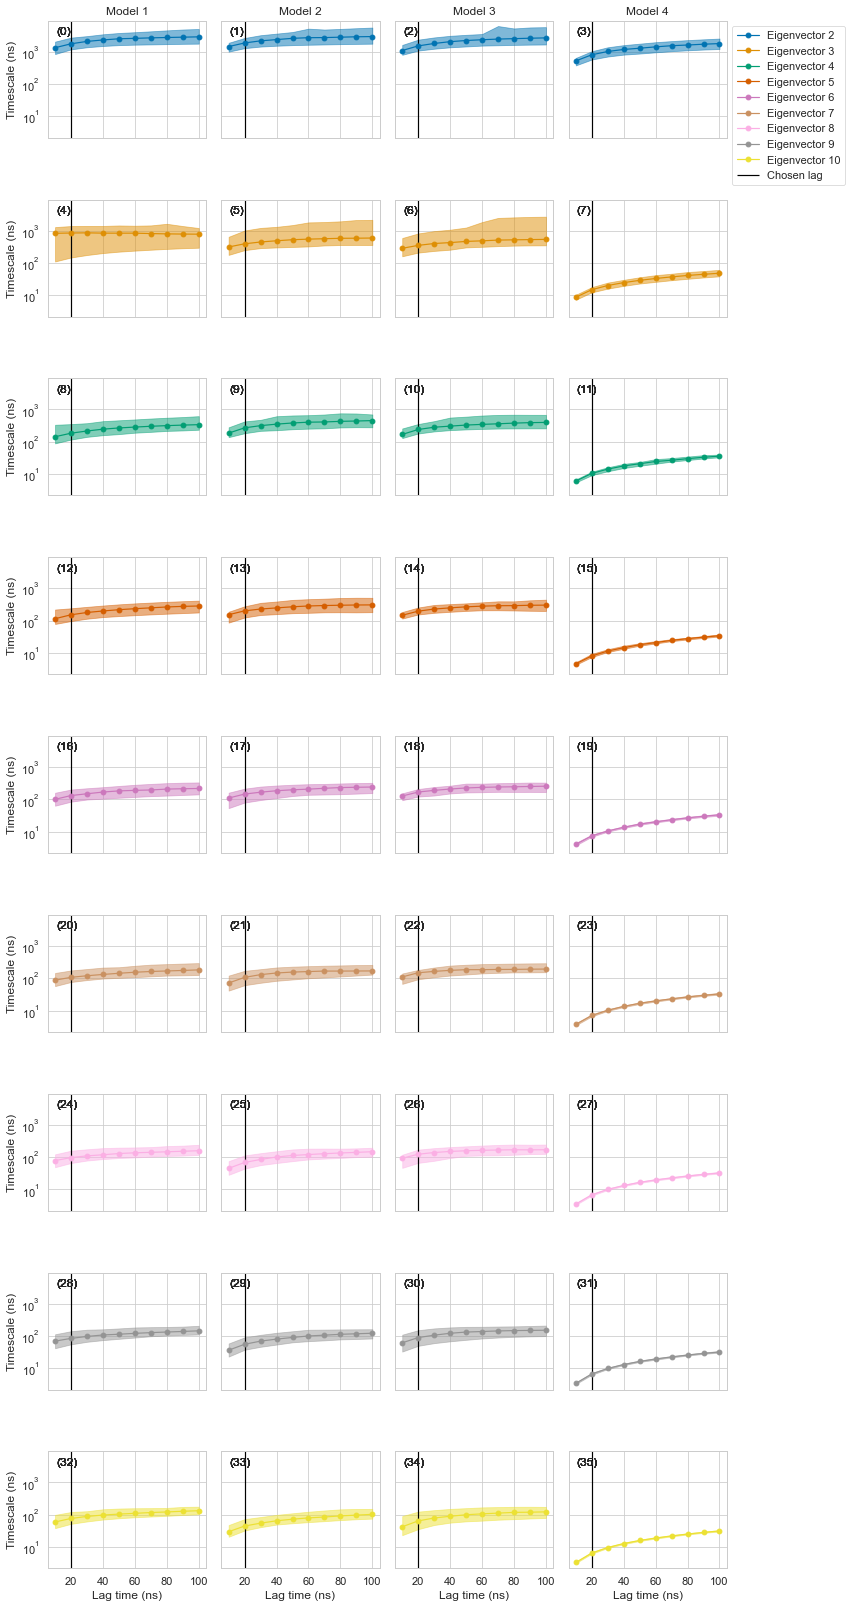

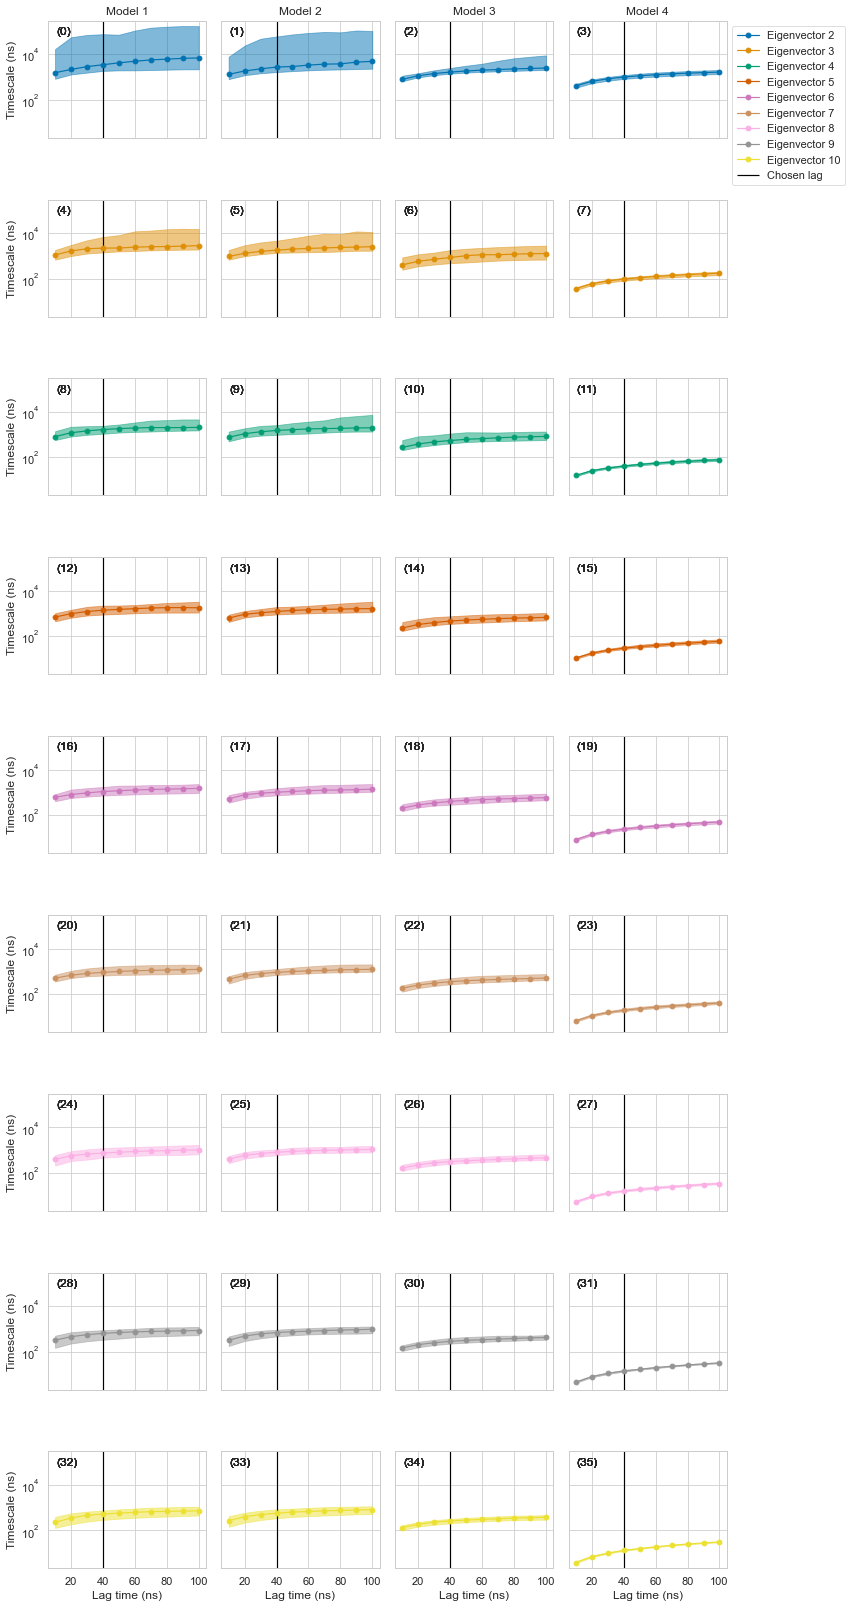

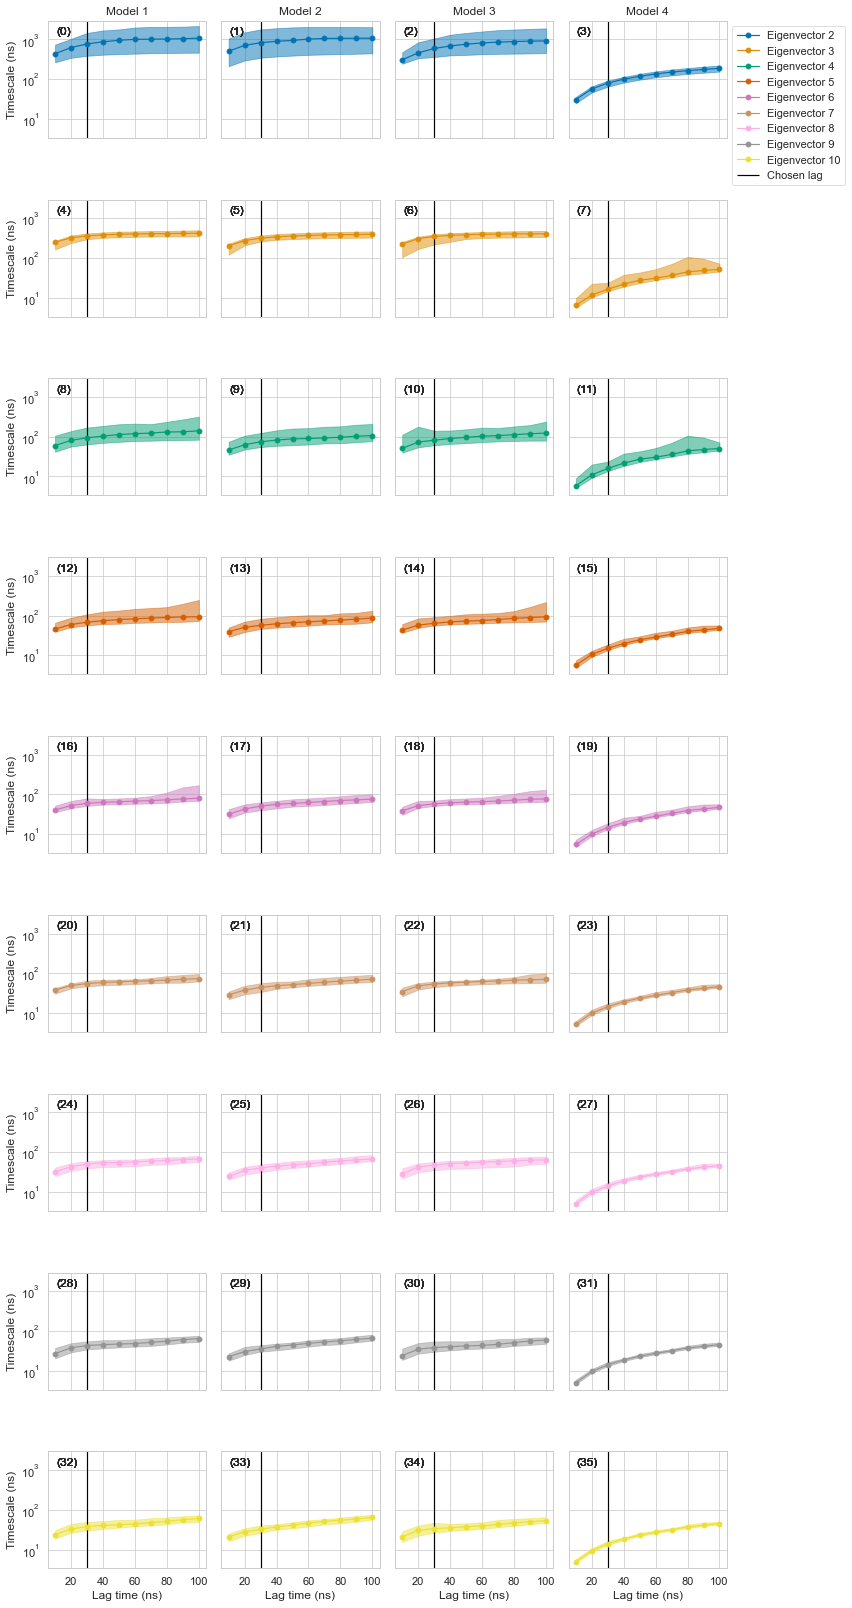

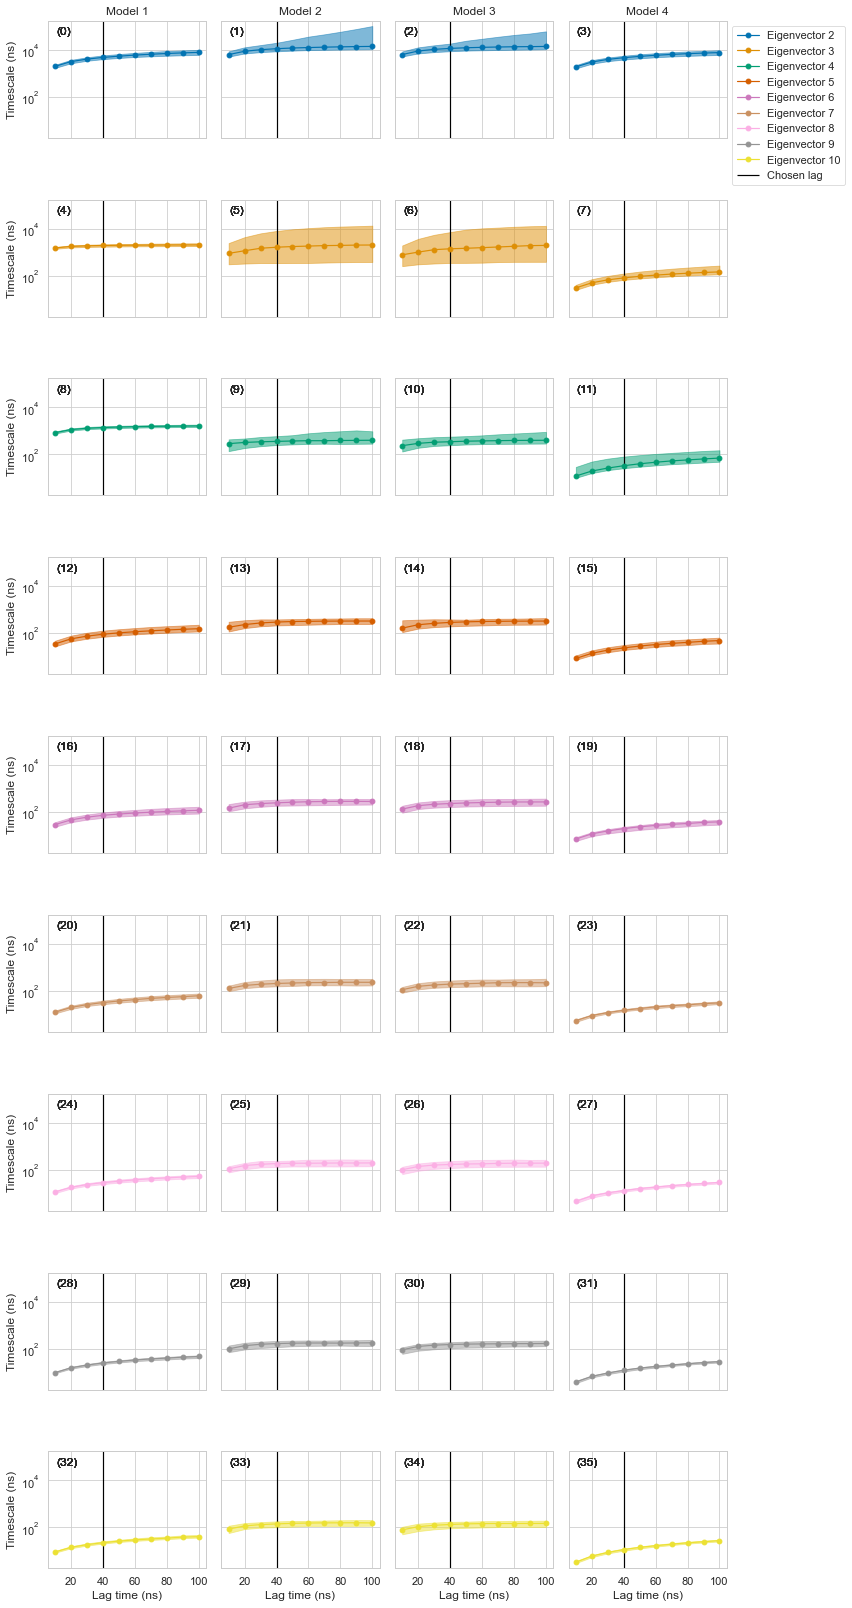

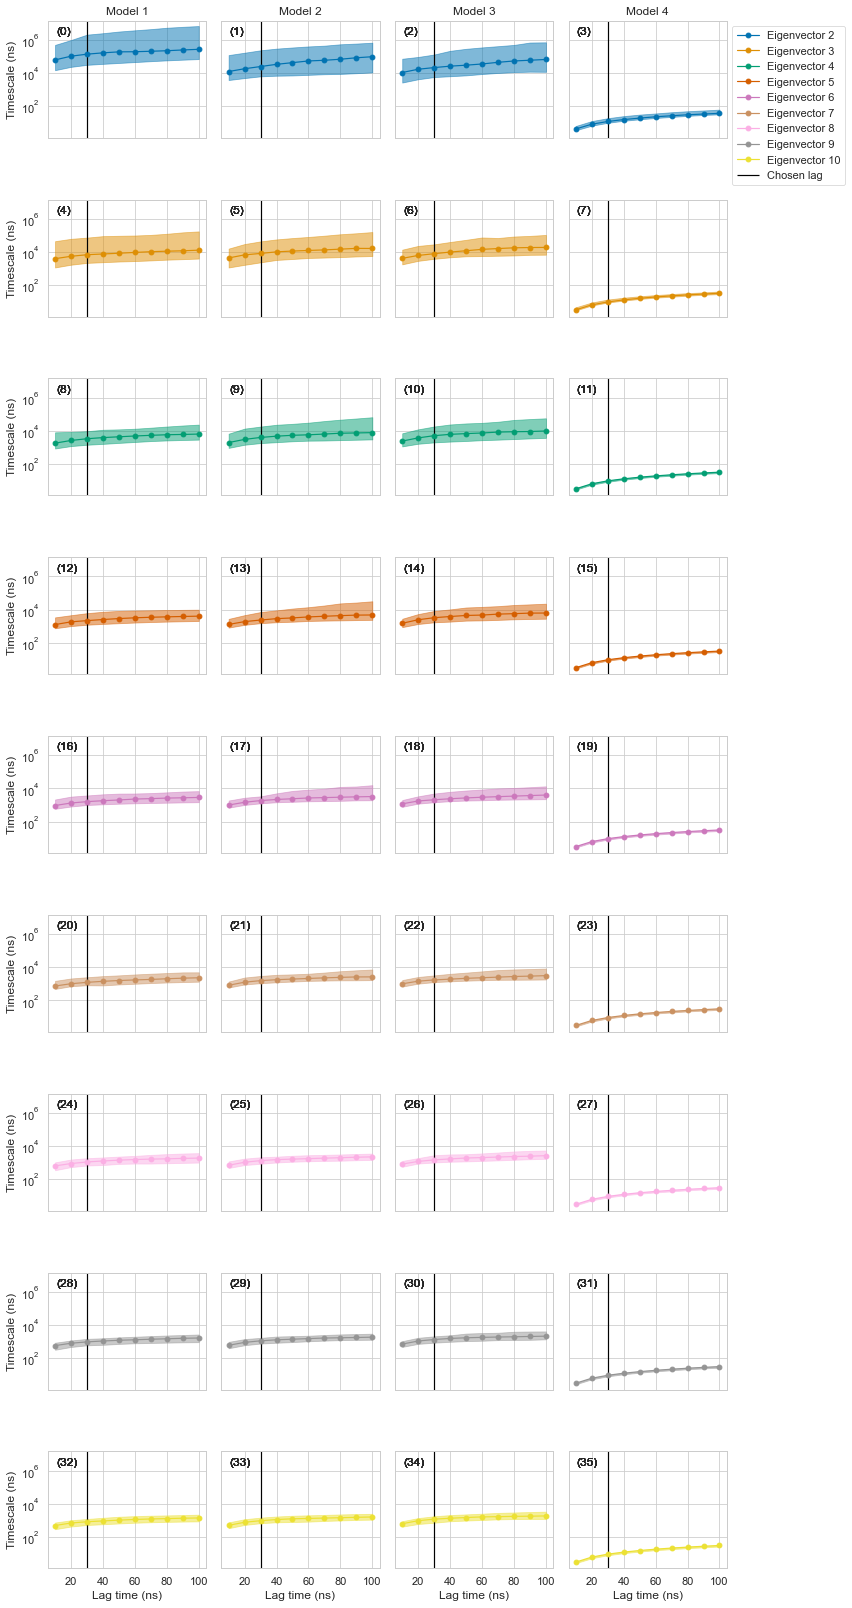

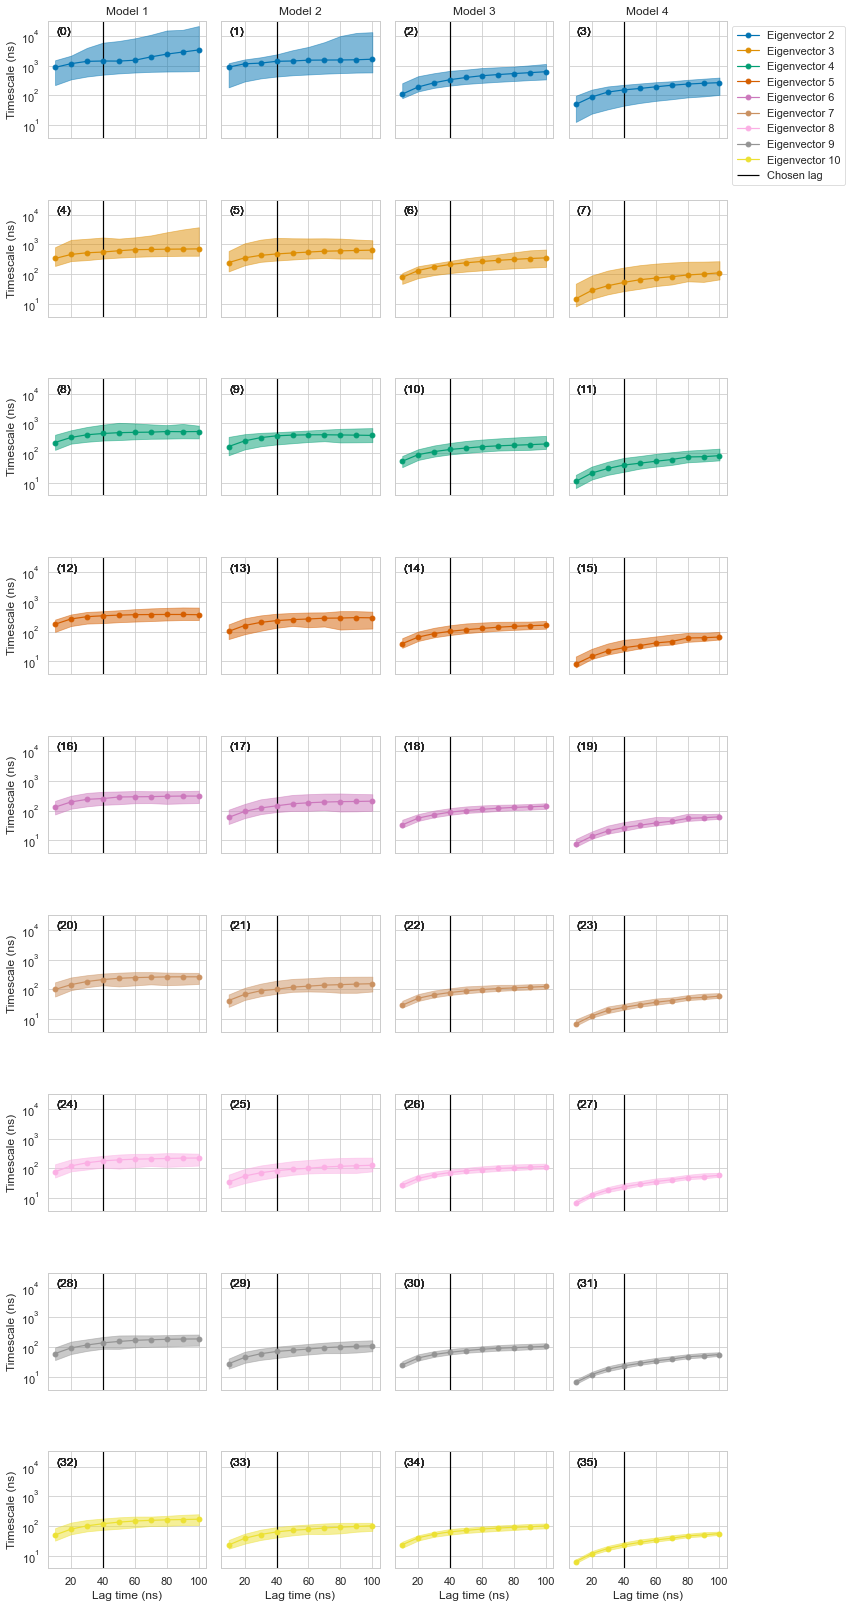

In [15]:
for protein in funcs.PROTEIN_DIRS[:5]+funcs.PROTEIN_DIRS[6:8]:

    model_defs = pd.read_hdf(data_dir.joinpath(protein, 'model_definitions.h5'))
    model_defs.sort_values(by='hp_rank', inplace=True)
    protein_fancy = model_defs.protein[0]

    model_labels = dict(zip(model_defs['hp_index'].values, np.arange(model_defs.shape[0])+1))
    lag = chosen_lags.loc[chosen_lags.protein==protein_fancy, 'lag'].values
    n_dom_proc = 10 # chosen_ks.loc[chosen_ks.protein==protein_fancy, 'num_its'].values[0] + 1


    big_ix = (timescales.protein==protein_fancy) & (timescales.hp_index.isin(model_defs.hp_index)) & (timescales.num_its <= n_dom_proc)
    use_ts = timescales.loc[big_ix, :].copy()
    use_ts['model'] = use_ts['hp_index'].apply(lambda x: model_labels[x])

    with sns.plotting_context('paper', font_scale=1.25):
        sns.set_style('whitegrid')

        col = 'model'
        row = 'num_its'
        x = 'lag'
        y = 'median'
        hue = 'num_its'
        df = use_ts

        x_label = 'Lag time (ns)'
        y_label = 'Timescale (ns)'

        col_vals = np.sort(df[col].unique())
        row_vals = np.sort(df[row].unique())
        hue_vals = np.sort(df[hue].unique())
        hues = sns.color_palette('colorblind', hue_vals.shape[0])

        fig, axes = plt.subplots(row_vals.shape[0], col_vals.shape[0], sharey=True, sharex=True, figsize=(12, 2.5*row_vals.shape[0]))
        if axes.ndim==1:
            axes = axes.reshape(1, -1)
        for j in range(col_vals.shape[0]):
            for i in range(row_vals.shape[0]):
                for k in range(hue_vals.shape[0]):

                    ix = (df[col]==col_vals[j]) & (df[row]==row_vals[i]) & (df[hue]==hue_vals[k])
                    xx = df.loc[ix, x]
                    yy = df.loc[ix, y]
                    ylb = df.loc[ix, 'lb'].values
                    yub = df.loc[ix, 'ub'].values
                    axes[i, j].plot(xx, yy, marker='o', label=f"Eigenvector {str(hue_vals[k])}", color=hues[k])
                    axes[i, j].fill_between(xx, ylb, yub, color=hues[k], alpha=0.5)
                    axes[i, j].set_yscale('log')

                    if i == row_vals.shape[0]-1:
                        axes[i, j].set_xlabel(x_label)
                    
                    if i == 0:
                        axes[i, j].set_title(f'Model {j+1}')
    
                    if j == 0:
                        axes[i, j].set_ylabel(y_label)



                    axes[i, j].annotate(text=f"({i*col_vals.shape[0]+j})", xy=(0.05, 0.95), xycoords='axes fraction', ha='left', va='top')

        for i in range(row_vals.shape[0]):
            ylim = axes[i, 0].get_ylim()
            for j in range(col_vals.shape[0]):
                    axes[i, j].vlines(lag, *ylim, label='Chosen lag', color='k')
                    axes[i, j].set_ylim(ylim)
                                    

        axes[0, -1].legend(bbox_to_anchor=(1, 1), loc='upper left')
                                    
        plt.tight_layout()
        plt.savefig(funcs.FIG_DIR.joinpath('comparator_its', f'{protein}_separate_with_errors.pdf'), bbox_inches='tight')

In [14]:
for protein in funcs.PROTEIN_DIRS[:5]+funcs.PROTEIN_DIRS[6:8]:

    model_defs = pd.read_hdf(data_dir.joinpath(protein, 'model_definitions.h5'))
    model_defs.sort_values(by='hp_rank', inplace=True)
    protein_fancy = model_defs.protein[0]

    model_labels = dict(zip(model_defs['hp_index'].values, np.arange(model_defs.shape[0])+1))
    lag = chosen_lags.loc[chosen_lags.protein==protein_fancy, 'lag'].values
    n_dom_proc = 10 # chosen_ks.loc[chosen_ks.protein==protein_fancy, 'num_its'].values[0] + 1


    big_ix = (timescales.protein==protein_fancy) & (timescales.hp_index.isin(model_defs.hp_index)) & (timescales.num_its <= n_dom_proc)
    use_ts = timescales.loc[big_ix, :].copy()
    use_ts['model'] = use_ts['hp_index'].apply(lambda x: model_labels[x])

    with sns.plotting_context('paper', font_scale=1.25):
        sns.set_style('whitegrid')

        col = 'model'
        row = 'num_its'
        x = 'lag'
        y = 'median'
        hue = 'num_its'
        df = use_ts

        x_label = 'Lag time (ns)'
        y_label = 'Timescale (ns)'

        col_vals = np.sort(df[col].unique())
        row_vals = np.sort(df[row].unique())
        hue_vals = np.sort(df[hue].unique())
        hues = sns.color_palette('colorblind', hue_vals.shape[0])

        fig, axes = plt.subplots(1, col_vals.shape[0], sharey=True, sharex=True, figsize=(6, 4))
        if axes.ndim==1:
            axes = axes.reshape(1, -1)
            
        i = 0
        for j in range(col_vals.shape[0]):
            for k in range(hue_vals.shape[0]):

                ix = (df[col]==col_vals[j]) & (df[row]==row_vals[i]) & (df[hue]==hue_vals[k])
                xx = df.loc[ix, x]
                yy = df.loc[ix, y]
                ylb = df.loc[ix, 'lb'].values
                yub = df.loc[ix, 'ub'].values
                axes[i, j].plot(xx, yy, marker='o', label=f"Eigenvector {str(hue_vals[k])}", color=hues[k])
                axes[i, j].fill_between(xx, ylb, yub, color=hues[k], alpha=0.5)
                axes[i, j].set_yscale('log')

                axes[i, j].set_xlabel(x_label)
                axes[i, j].set_title(f'Model {j+1}')

                if j == 0:
                    axes[i, j].set_ylabel(y_label)



                axes[i, j].annotate(text=f"({i*col_vals.shape[0]+j})", xy=(0.05, 0.95), xycoords='axes fraction', ha='left', va='top')

        for i in range(row_vals.shape[0]):
            ylim = axes[i, 0].get_ylim()
            for j in range(col_vals.shape[0]):
                    axes[i, j].vlines(lag, *ylim, label='Chosen lag', color='k')
                    axes[i, j].set_ylim(ylim)
                                    

        axes[0, -1].legend(bbox_to_anchor=(1, 1), loc='upper left')
                                    
        plt.tight_layout()
        plt.savefig(funcs.FIG_DIR.joinpath('comparator_its', f'{protein}_compbined_no_errors.pdf'), bbox_inches='tight')

array([2, 3, 4, 5, 6, 7, 8, 9])